- Name: Graydon Sinclair
- Github: https://github.com/grsi7978/CSPB_3202_Competition/tree/main 

In [350]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Cropping2D, Input, Rescaling
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc


## The Problem

The problem that I am trying to tackle with this assignment is the identification of metastatic cancer in small image patches taken from larger digital pathology scans. The images themselves are 96x96 pixels in size. It is important to note, per the link provided via the Kaggle competition page (https://github.com/basveeling/pcam) that if the center 32x32px region of a path contains at least one pixel of tumor tissue it is considered a positive. Any tumor tissue in the outter regions of the image does not create a positive. The images have been pre-split into training, validation, and testing sets for this competition. The training set contains 262,144 images. The validation and testing sets contain 32,768 images each. There should be a 50/50 split between the positive and negative labeled images (I determine this is in fact false below).

## EDA

#### View Images

First I will make sure that I have access to the images and that I am able to properly read them.

In [351]:
def present_images(dir, count=10):
    dirs=os.listdir(dir)
    files=[os.path.join(dir,file) for file in dirs][:count]
    
    plt.figure(figsize=(10,10))
    for idx,img_path in enumerate(files):
        plt.subplot(5,5,idx+1)
        img=plt.imread(img_path)
        plt.imshow(img)
        
    plt.tight_layout()

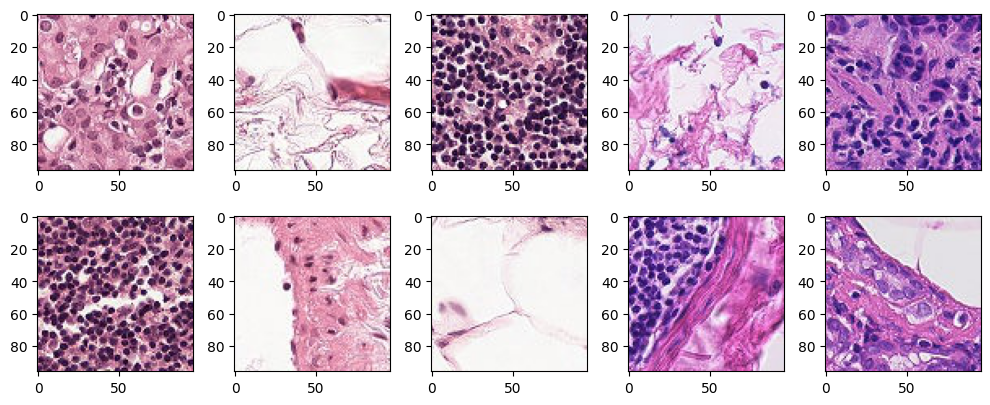

In [352]:
present_images("../histopathologic-cancer-detection/train")

#### Cleaning

Next I will determine how many images there are in the training and test sets, and how many labels we are provided in the labels csv.

In [353]:
training_labels = pd.read_csv('../histopathologic-cancer-detection/train_labels.csv')
num_train_images = len(os.listdir('../histopathologic-cancer-detection/train'))
num_test_images = len(os.listdir('../histopathologic-cancer-detection/test'))

print(f"Number of labels: {training_labels.shape[0]}")
print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")

Number of labels: 220025
Number of training images: 220025
Number of test images: 57458


Next I will make sure the data is clean by verifying there are no null values or duplicate values.

In [354]:
print(f"Duplicate values: {training_labels.duplicated().sum()}")
print("Missing Values: ")
print(training_labels.isnull().sum())

Duplicate values: 0
Missing Values: 
id       0
label    0
dtype: int64


From the kaggle description we know "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue." With this information I am curious to see what the distribution between the malignant and benign images are so we will check this to see if there is an even split.

In [355]:
benign_count = (training_labels['label'] == 0).sum()
print(f"Benign image count: {benign_count}")

malignant_count = (training_labels['label'] == 1).sum()
print(f"Malignant image count: {malignant_count}")

print(f"Benign to Malignant Ratio: {benign_count / malignant_count}")

Benign image count: 130908
Malignant image count: 89117
Benign to Malignant Ratio: 1.468945319074924


We can see here that there is not a 50/50 split of the images as we may expect. In fact there are many more images labeled as benign in the dataset. This may be a factor in the learning of the model we build.

Overall no cleaning is needed but there is some interesting information learned about the data from the above EDA processes.

The next step is to create the Training and Test data out of the provided data. 

I will use a random state to ensure reproducibility and set the number of rows I want to sample to 50000 for now. This number is large and below the 89117 count of Malignant images provided, but otherwise arbitrary.

In [356]:
benign_samples = training_labels[training_labels['label'] == 0].sample(n=50000, random_state=23)
malignant_samples = training_labels[training_labels['label'] == 1].sample(n=50000, random_state=23)
# combine the two sets into one, dropping the old index and not including it as a col
combined_samples = pd.concat([benign_samples, malignant_samples], axis=0).reset_index(drop=True) 
# shuffle the dataframe so the two old dataframes are not just stacked on top of eachother
combined_samples = combined_samples.sample(frac=1).reset_index(drop=True)

Let's ensure that we now have a 50/50 split in our combined data set.

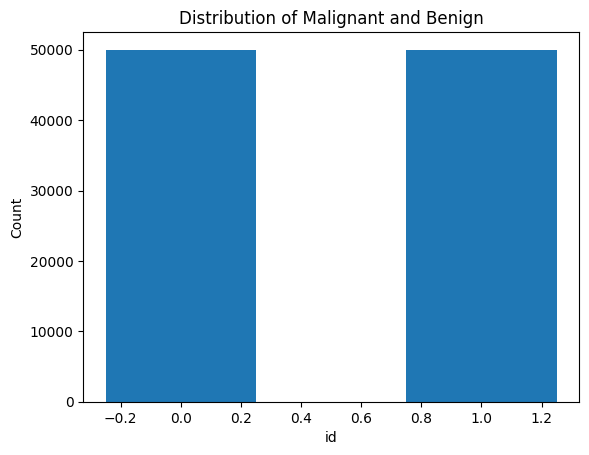

In [357]:
plt.hist(combined_samples['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.5)
plt.xlabel('id')
plt.ylabel('Count')
plt.title('Distribution of Malignant and Benign')
plt.show()

We can see that there is infact even distribution between the malignant and benign labels in our combined data.

Now I will split the data into training and testing sets.

In [358]:
# stratify ensures that the proportion of malignant and benign are maintained across both sets
training_df, validation_df = train_test_split(combined_samples, test_size=.20, random_state=23, stratify=combined_samples['label'])

In [359]:
print(f"training_df shape: {training_df.shape}")
print(f"validation_df shape: {validation_df.shape}")

training_df shape: (80000, 2)
validation_df shape: (20000, 2)


## CNN Model

I have opted to build a Convolutional Neural Network Model as it is the most commonly used model for deep learning regarding image related tasks due to their feature extraction, spactial invariance, parameter efficiency and other aspects. 

#### Tensorflow

I will use the Tensorflow library to facilitate the building of the CNN.

To use Tensorflow the easiest way I have found is to store the images used in the testing and validation in their own folders. We will do this manually here.

In [360]:
image_dir = 'image_dir'
os.makedirs(image_dir)

In [361]:
training_images = os.path.join(image_dir, 'training')
os.mkdir(training_images)
benign_path = os.path.join(training_images, 'benign')
os.mkdir(benign_path)
malignant_path = os.path.join(training_images, 'malignant')
os.mkdir(malignant_path)

validation_images = os.path.join(image_dir, 'validation')
os.mkdir(validation_images)
benign_path = os.path.join(validation_images, 'benign')
os.mkdir(benign_path)
malignant_path = os.path.join(validation_images, 'malignant')
os.mkdir(malignant_path)

Now that I have created the folders I just need to move the images associated with the split of the ids/labels that I did above into the correct folders.

In [362]:
combined_samples.set_index('id', inplace=True)

In [363]:
def get_images(id_list, destination_dir):
    for id in id_list:
        image_name = id + '.tif'
        
        label = combined_samples.loc[id, 'label']

        if label == 0:
            file_label = 'benign'
        else:
            file_label = 'malignant'
        final_destination_dir = os.path.join(destination_dir, file_label)

        image_source = os.path.join('../histopathologic-cancer-detection/train', image_name)
        image_destination = os.path.join(final_destination_dir, image_name)

        shutil.copy(image_source, image_destination)

In [364]:
training_ids = training_df['id'].tolist()
validation_ids = validation_df['id'].tolist()

In [365]:
get_images(training_ids, training_images)

In [366]:
get_images(validation_ids, validation_images)

Now I will verify that the correct amount of images have been copied into each of the validation and training folders.

In [367]:
print(f"Number of files in the Training Benign Images Set: {len(os.listdir('image_dir/training/benign'))}")
print(f"Number of files in the Training Malignant Images Set: {len(os.listdir('image_dir/training/malignant'))}")
print(f"Number of files in the Validation Benign Images Set: {len(os.listdir('image_dir/validation/benign'))}")
print(f"Number of files in the Validation Malignant Images Set: {len(os.listdir('image_dir/validation/malignant'))}")

Number of files in the Training Benign Images Set: 40000
Number of files in the Training Malignant Images Set: 40000
Number of files in the Validation Benign Images Set: 10000
Number of files in the Validation Malignant Images Set: 10000


This is what I expect so will continue forward.

In [368]:
train_datagen = ImageDataGenerator()
training = train_datagen.flow_from_directory('./image_dir/training', target_size=(96,96), batch_size=32, class_mode='binary', shuffle=False)

Found 80000 images belonging to 2 classes.


In [369]:
valid_datagen = ImageDataGenerator()
validation = valid_datagen.flow_from_directory('image_dir/validation', target_size=(96,96), batch_size=32, class_mode='binary', shuffle=False)

Found 20000 images belonging to 2 classes.


Again this is what I expect to see, the correct number of images split across 2 classes in each folder, so I will continue.

#### Model 1

I will now build the model using Tensorflow.

In [370]:
model = Sequential([
    Input(shape=(96,96,3)), 
    Rescaling(1.0/255), 
    Cropping2D(cropping=((16,16),(16,16))),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ])

In [371]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_2 (Cropping2D)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Now I will fit the model with the data we have compiled.

In [372]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'auc'])

For the sake of time I will limit the number of training and validation steps to 100 times smaller than the number of items in the training and validation sets respectively. 

In [379]:
training_steps = int(np.ceil(len(training_df)/10))
validation_steps = int(np.ceil(len(validation_df)/10))

In [380]:
history = model.fit(training, steps_per_epoch=training_steps, epochs=10, validation_data=validation, validation_steps=validation_steps)


Epoch 1/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - accuracy: 0.7514 - auc: 0.8239 - loss: 0.5168 - val_accuracy: 0.7680 - val_auc: 0.8441 - val_loss: 0.4968
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 88s 11ms/step - accuracy: 0.7694 - auc: 0.8448 - loss: 0.4939 - val_accuracy: 0.7703 - val_auc: 0.8488 - val_loss: 0.4838
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - accuracy: 0.8011 - auc: 0.8754 - loss: 0.4439 - val_accuracy: 0.7688 - val_auc: 0.8458 - val_loss: 0.4900
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - accuracy: 0.8267 - auc: 0.9007 - loss: 0.3987 - val_accuracy: 0.7644 - val_auc: 0.8412 - val_loss: 0.5026
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - accuracy: 0.8495 - auc: 0.9219 - loss: 0.3569 - val_accuracy: 0.7663 - val_auc: 0.8368 - val_loss: 0.5404
Epoch 6/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - accuracy: 0.8729 - auc: 0.9419 - loss: 0.3088 - val_accuracy: 0.7584 - val_auc: 0.8358 - val_loss: 0.5848
Epoch 7/10
8000

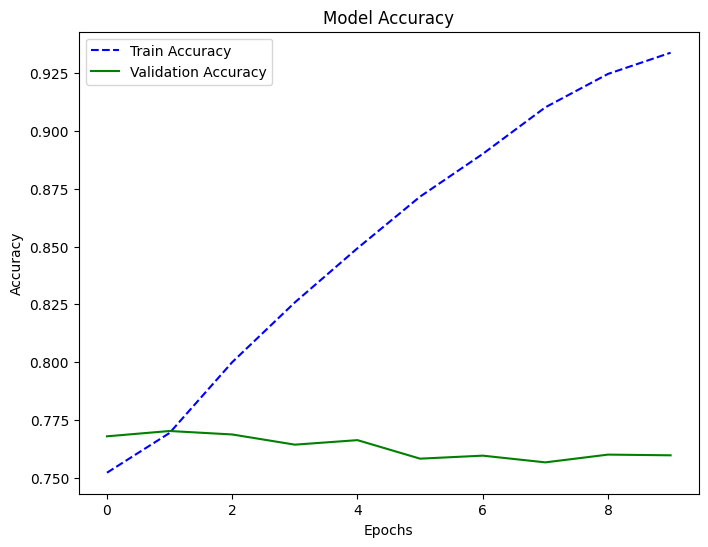

In [381]:
plt.figure(figsize=(8, 6))

plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle="dashed")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

- This kind of gap between the training and validation accuracy indicates that  the model may be memorizing the training data rather than truely learning
    - To help mitigate this I will add some dropout layers


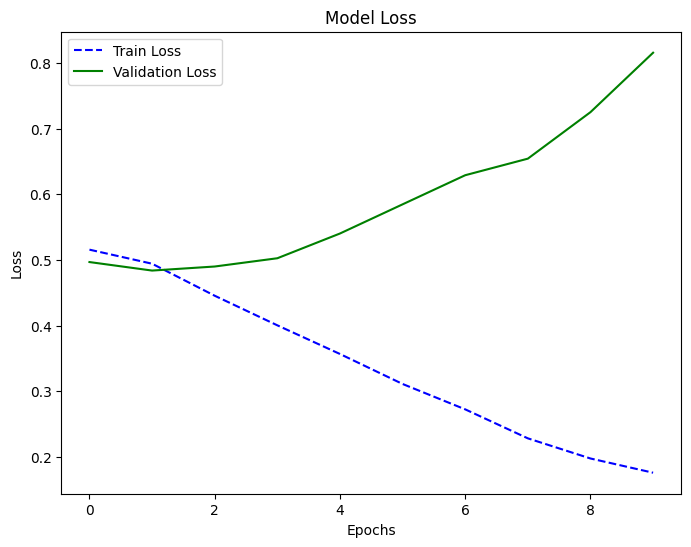

In [402]:
plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle="dashed")
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

- This Loss graph indicates that the model is successfully learning from the training data
- However it also indicates that it is not gernarlizing to the balidation data, making poor decisions as the epochs continue as the loss for validation rises over time

#### Model 2

Now I will make a second model with some of the hyperparameters changed for tuning purposes. I have dropped the cropping, and added Dropout as well as another Dense layer. I removed cropping to see if this improves the process. It is only the center of the image that should matter but maybe the cropping is doing too much. In this new model I added more Convolution layers in an attempt to extract more complex features. Adding the multiple Dropout steps should help with overfitting.


In [386]:
model_2 = Sequential([
    Input(shape=(96,96,3)), 
    Rescaling(1.0/255), 
    Conv2D(32,(3,3),activation='relu'),
    Conv2D(32,(3,3),activation='relu'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),    
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),    
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ])

model_2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,693,697 (6.46 MB)

 Trainable params: 1,693,697 (6.46 MB)

 Non-trainable params: 0 (0.00 B)

In [387]:
model_2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy', 'auc'])

In [388]:
training_steps_2 = int(np.ceil(len(training_df)/10))
validation_steps_2 = int(np.ceil(len(validation_df)/10))

In [389]:
history_2 = model_2.fit(training, steps_per_epoch=training_steps_2, epochs=10, validation_data=validation, validation_steps=validation_steps_2)


Epoch 1/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 566s 70ms/step - accuracy: 0.6556 - auc: 0.7257 - loss: 0.6002 - val_accuracy: 0.7631 - val_auc: 0.8578 - val_loss: 0.4984
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 420s 52ms/step - accuracy: 0.7684 - auc: 0.8401 - loss: 0.4976 - val_accuracy: 0.7681 - val_auc: 0.8674 - val_loss: 0.4964
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 419s 52ms/step - accuracy: 0.7842 - auc: 0.8598 - loss: 0.4687 - val_accuracy: 0.8115 - val_auc: 0.8914 - val_loss: 0.4239
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 419s 52ms/step - accuracy: 0.8070 - auc: 0.8834 - loss: 0.4311 - val_accuracy: 0.8224 - val_auc: 0.9022 - val_loss: 0.3983
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 418s 52ms/step - accuracy: 0.8159 - auc: 0.8940 - loss: 0.4121 - val_accuracy: 0.8355 - val_auc: 0.9144 - val_loss: 0.3744
Epoch 6/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 418s 52ms/step - accuracy: 0.8228 - auc: 0.9013 - loss: 0.3988 - val_accuracy: 0.8340 - val_auc: 0.9197 - val_loss: 0.3684
Epoch 7/10

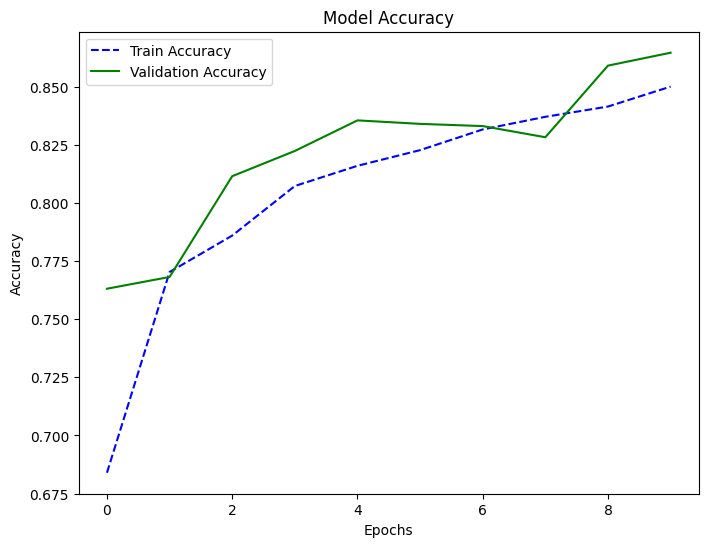

In [390]:
plt.figure(figsize=(8, 6))

plt.plot(history_2.history['accuracy'], label='Train Accuracy', color='blue', linestyle="dashed")
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy', color='green')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

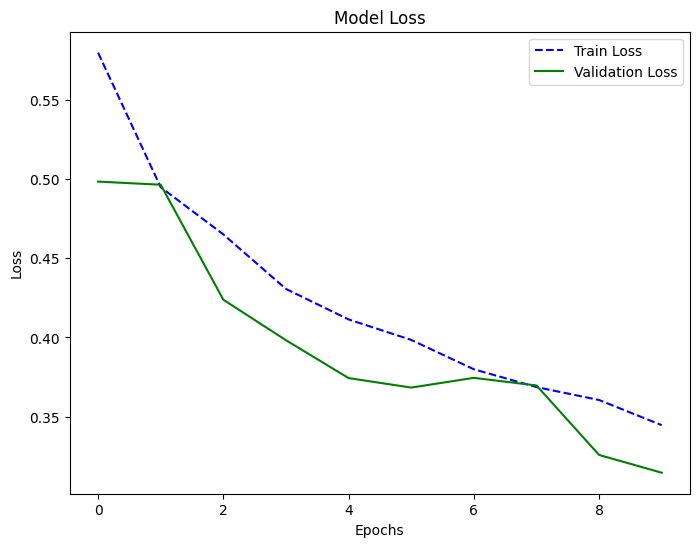

In [401]:
plt.figure(figsize=(8, 6))

plt.plot(history_2.history['loss'], label='Train Loss', color='blue', linestyle="dashed")
plt.plot(history_2.history['val_loss'], label='Validation Loss', color='green')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

- This model is a represents a noticeable improvement over model 1
- The overfitting has been removed and the overall accuracy, especially in the validation has improved
- The loss is decreasing over time indicating the model is learning

#### Model 3

- Now I will attempt a third iteration
    - Here I have removed some of the convolution layers to see if they are all necessary
    - I have added BatchNormalization to speed up the training and normalize the activations
    - I have added regularizers to help prevent overfitting like we saw in model 1

In [395]:
model_3 = Sequential([
    Input(shape=(96,96,3)), 
    Rescaling(1.0/255), 
    Cropping2D(cropping=((16,16),(16,16))),
    
    Conv2D(32,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),    
    
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),    
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    ])

model_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_4 (Cropping2D)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,417 (2.64 MB)

 Trainable params: 691,969 (2.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [396]:
training_steps_3 = int(np.ceil(len(training_df)/10))
validation_steps_3 = int(np.ceil(len(validation_df)/10))

I will also use ReduceLROnPlateau to reduce the learning rate when training is stalling. This should help optimize the learning process.

In [397]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, mode='min')

In [398]:
model_3.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'auc'])

history_3 = model_3.fit(training, steps_per_epoch=training_steps_3, epochs=10, validation_data=validation, validation_steps=validation_steps_3, callbacks=[reduce_lr])

Epoch 1/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 255s 31ms/step - accuracy: 0.8771 - auc: 0.9391 - loss: 0.7129 - val_accuracy: 0.5299 - val_auc: 0.6685 - val_loss: 1.6890 - learning_rate: 0.0010
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 287s 36ms/step - accuracy: 0.9559 - auc: 0.9877 - loss: 0.2822 - val_accuracy: 0.3961 - val_auc: 0.3262 - val_loss: 2.8191 - learning_rate: 0.0010
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 298s 37ms/step - accuracy: 0.9689 - auc: 0.9931 - loss: 0.2278 - val_accuracy: 0.4971 - val_auc: 0.3939 - val_loss: 1.2029 - learning_rate: 0.0010
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 289s 36ms/step - accuracy: 0.9525 - auc: 0.9869 - loss: 0.2651 - val_accuracy: 0.5950 - val_auc: 0.6158 - val_loss: 1.3740 - learning_rate: 0.0010
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 254s 32ms/step - accuracy: 0.9782 - auc: 0.9961 - loss: 0.1588 - val_accuracy: 0.5411 - val_auc: 0.5890 - val_loss: 2.4461 - learning_rate: 0.0010
Epoch 6/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 180s 22ms/ste

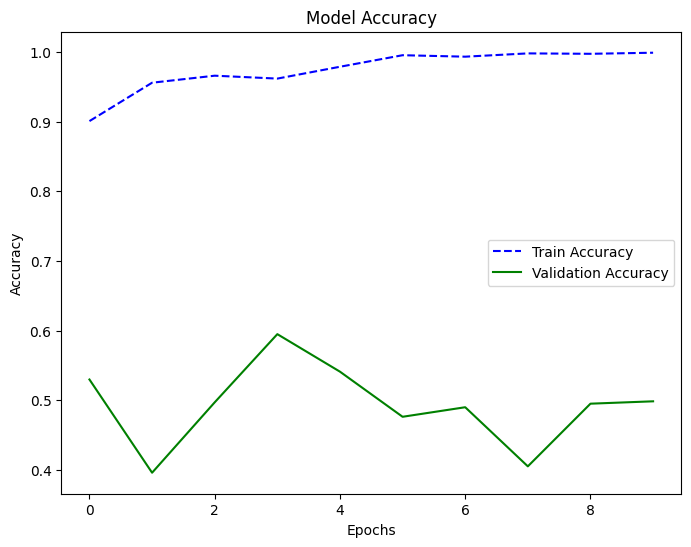

In [403]:
plt.figure(figsize=(8, 6))

plt.plot(history_3.history['accuracy'], label='Train Accuracy', color='blue', linestyle="dashed")
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy', color='green')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

- The validation accuracy is much worse than it was in both model 1 and 2
    - This may be because of the Regularization (L2) that was added in the hopes to help prevent overfitting
    - This may be because of the increases dropout values (0.3->0.5)

Lets also look at the loss.

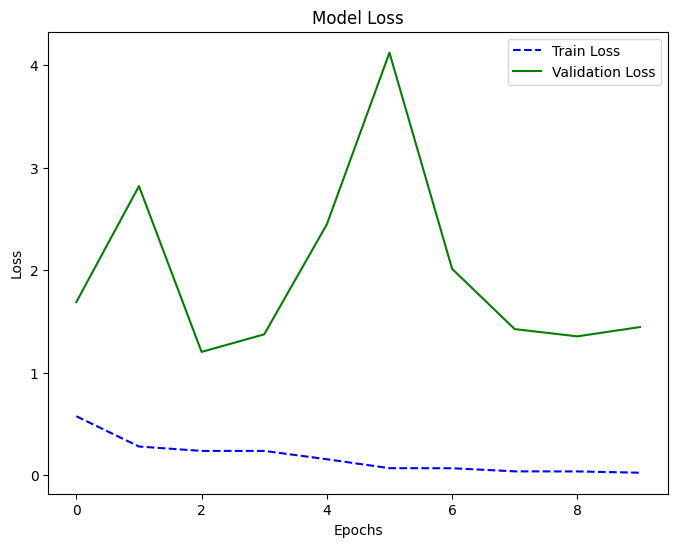

In [404]:
plt.figure(figsize=(8, 6))

plt.plot(history_3.history['loss'], label='Train Loss', color='blue', linestyle="dashed")
plt.plot(history_3.history['val_loss'], label='Validation Loss', color='green')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

We can see that the loss doesn't really change indicating that the model is not learning.

#### ROC

To get a better idea of if model 1 or model 2 is better I will use ROC and AUC.

In [406]:
y_pred_1 = model.predict(validation, steps=validation.samples // validation.batch_size + 1)
y_pred_2 = model_2.predict(validation, steps=validation.samples // validation.batch_size + 1)
y_true = validation.classes

626/626 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step


In [407]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_true, y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)
print(f"AUC for Model 1: {roc_auc_1:.2f}")

fpr_2, tpr_2, thresholds_2 = roc_curve(y_true, y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)
print(f"AUC for Model 2: {roc_auc_2:.2f}")

AUC for Model 1: 0.82
AUC for Model 2: 0.94


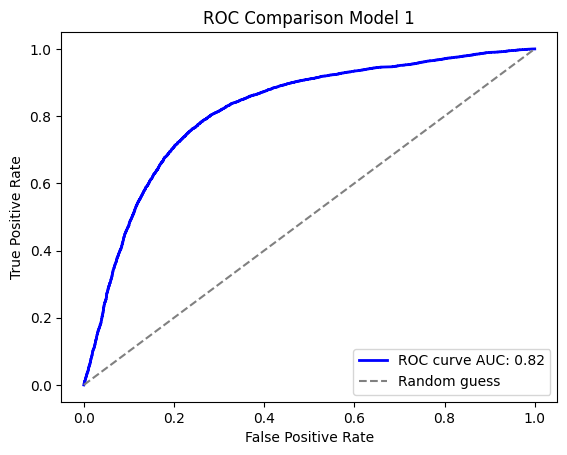

In [408]:
plt.figure()
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f"ROC curve AUC: {roc_auc_1:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison Model 1")
plt.legend(loc='lower right')
plt.show()

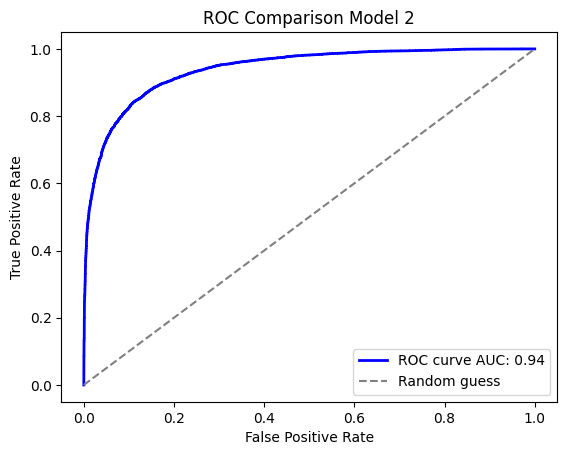

In [409]:
plt.figure()
plt.plot(fpr_2, tpr_2, color='blue', lw=2, label=f"ROC curve AUC: {roc_auc_2:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison Model 2")
plt.legend(loc='lower right')
plt.show()

- We can see from both the ROC curves that model 1 and 2 are both performing well, however it is clear that model 2 performs better, as I expected based off the validation accuracy numbers above

## Submission

I will submit to the competition using model 2's functionality. Below is the code I used to generate the submission.

In [410]:
sample_csv = pd.read_csv("../histopathologic-cancer-detection/sample_submission.csv")
sample_csv.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [417]:
sample_ids = sample_csv['id'].tolist()
len(sample_ids)

57458

In [412]:
sample_images = os.path.join(image_dir, 'sample')
os.mkdir(sample_images)
benign_path = os.path.join(sample_images, 'benign')
os.mkdir(benign_path)
malignant_path = os.path.join(sample_images, 'malignant')
os.mkdir(malignant_path)

In [420]:
def get_test_images(id_list, destination_dir):
    for id in id_list:
        image_name = id + '.tif'
        
        label = sample_csv[sample_csv['id'] == id]['label'].values[0]

        if label == 0:
            file_label = 'benign'
        else:
            file_label = 'malignant'
        final_destination_dir = os.path.join(destination_dir, file_label)

        image_source = os.path.join('../histopathologic-cancer-detection/test', image_name)
        image_destination = os.path.join(final_destination_dir, image_name)

        shutil.copy(image_source, image_destination)

In [421]:
get_test_images(sample_ids, sample_images)

In [422]:
sample_datagen = ImageDataGenerator()
sample = sample_datagen.flow_from_directory('image_dir/sample', target_size=(96,96), batch_size=32, class_mode='binary', shuffle=False)

Found 57458 images belonging to 2 classes.


In [423]:
y_pred_sample = model_2.predict(sample)

C:\Users\gssin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 329s 183ms/step


In [424]:
print(y_pred_sample[0])

[0.78643465]


In [425]:
y_pred_sample = y_pred_sample.ravel()
submission = pd.DataFrame({
    'id': sample_csv['id'],
    'label': y_pred_sample
})
submission.to_csv('CNN_submission.csv', index=False)

I submitted model 2's results to the competition to see what score I got and you can see the output below.

<img src="score_3.png" alt="Comp" width="500">

This is a little surprising and disappointing based of the validation accuracy scores I was getting so I will try some further modeling tweaks.

## Further Modeling

After submitting I continued to reasearch ways to improve the model due to the lackluster score I received. Below are some additional models that I created.

Through some research online I found that there is a hyperparameter tuning library KerasTuner (https://keras.io/keras_tuner/getting_started/). I will leverage that here to see if I can get a better model. I have kept the model primarily the same as model 3 for now with the addition of using the Choice function to allow for the tuner to determine the best Dropout and Learning Rates.

In [426]:
from keras_tuner import HyperModel, RandomSearch

In [ ]:
def build_model(hp):
    model = Sequential([
        Input(shape=(96,96,3)), 
        Rescaling(1.0/255), 
        Cropping2D(cropping=32),
        Conv2D(32,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),    
        
        Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),    
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(hp.Choice("dropout_rate", [0.3, 0.5])),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])), loss='binary_crossentropy',
        metrics=['accuracy', 'auc']
    )

    return model

model_4_tuning = RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='model_4'
)

model_4_tuning.search(x=training, validation_data=validation, steps_per_epoch=int(np.ceil(len(training_df)/1000)), epochs=15)

Trial 4 Complete [00h 02m 33s]
val_accuracy: 0.6035000085830688

Best val_accuracy So Far: 0.6035000085830688
Total elapsed time: 00h 09m 57s


Now I can use the RandomSearch to retrieve the best model it found. Below I also print out the summary of the model that was determined to be the best out of all the iterations.

In [325]:
model_4 = model_4_tuning.get_best_models(num_models=1)[0]
model_4.summary()

C:\Users\gssin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,129 (656.75 KB)

 Trainable params: 167,681 (655.00 KB)

 Non-trainable params: 448 (1.75 KB)

Now I can use the RandomSearch to get the best hyperparameters just like I did to get the best model. I will also introduce a learning rate reduction like I did in model 3. I will also leverage EarlyStopping to help prevent overfitting and not waste time completeing unecessary training when there is no imporvement occuring.

In [330]:
hyperparameters = model_4_tuning.get_best_hyperparameters()[0]
learning_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

final_model = build_model(hyperparameters)

In [331]:
history_4 = final_model.fit(training, epochs=15, validation_data=validation, callbacks=[learning_reduction, early_stop])

Epoch 1/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - accuracy: 0.8665 - auc: 0.9248 - loss: 1.3569 - val_accuracy: 0.5003 - val_auc: 0.4889 - val_loss: 1.5303 - learning_rate: 1.0000e-04
Epoch 2/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 68s 24ms/step - accuracy: 0.9932 - auc: 0.9991 - loss: 0.4547 - val_accuracy: 0.4506 - val_auc: 0.3855 - val_loss: 2.7705 - learning_rate: 1.0000e-04
Epoch 3/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 65s 23ms/step - accuracy: 0.9944 - auc: 0.9986 - loss: 0.2413 - val_accuracy: 0.4690 - val_auc: 0.5071 - val_loss: 1.2454 - learning_rate: 1.0000e-04
Epoch 4/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 64s 23ms/step - accuracy: 0.9957 - auc: 0.9990 - loss: 0.1637 - val_accuracy: 0.5060 - val_auc: 0.5184 - val_loss: 1.7435 - learning_rate: 1.0000e-04
Epoch 5/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 67s 24ms/step - accuracy: 0.9965 - auc: 0.9992 - loss: 0.1217 - val_accuracy: 0.5265 - val_auc: 0.5311 - val_loss: 1.0148 - learning_rate: 1.0000e-04
Epoch 6/15
2813/2813 ━━━━━━━━━━━━━━━━━━━

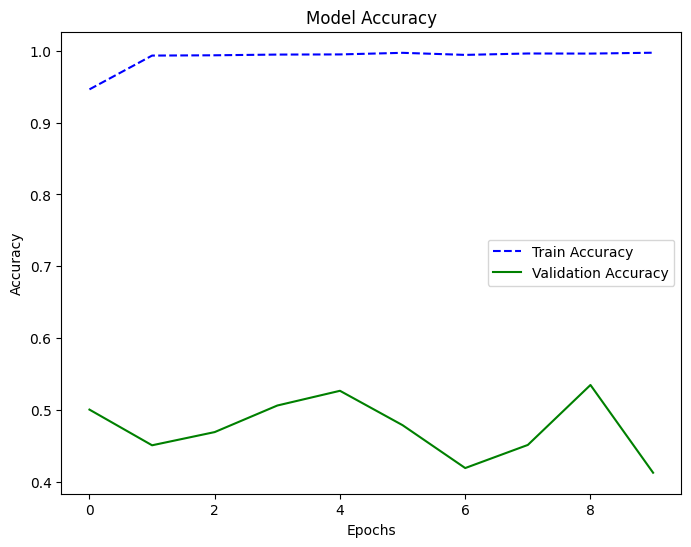

In [332]:
plt.figure(figsize=(8, 6))

plt.plot(history_4.history['accuracy'], label='Train Accuracy', color='blue', linestyle="dashed")
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy', color='green')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

It is clear that this model performed worse than model 1 which is expected since it is based on model 3. 

Let's try the tuning with model 1 as the base model:

In [338]:
def build_model_2(hp):
    model = Sequential([
        Input(shape=(96,96,3)), 
        Rescaling(1.0/255), 
        Cropping2D(cropping=((16,16),(16,16))),
        
        Conv2D(32,(3,3),activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),  

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(hp.Choice("dropout_rate", [0.3, 0.5])),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])), loss='binary_crossentropy',
        metrics=['accuracy', 'auc']
    )

    return model

model_5_tuning = RandomSearch(
    build_model_2,
    objective='val_accuracy',
    directory='model_5'
)

model_5_tuning.search(x=training, validation_data=validation, steps_per_epoch=int(np.ceil(len(training_df)/100)), epochs=15)

Trial 4 Complete [00h 12m 44s]
val_accuracy: 0.6176000237464905

Best val_accuracy So Far: 0.6331999897956848
Total elapsed time: 00h 51m 52s


In [339]:
model_5 = model_5_tuning.get_best_models(num_models=1)[0]
model_5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,665 (6.20 MB)

 Trainable params: 1,625,473 (6.20 MB)

 Non-trainable params: 192 (768.00 B)

In [340]:
hyperparameters = model_5_tuning.get_best_hyperparameters()[0]

final_2_model = build_model_2(hyperparameters)

history_5 = final_2_model.fit(training, epochs=15, validation_data=validation, callbacks=[learning_reduction, early_stop])

Epoch 1/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 175s 62ms/step - accuracy: 0.8187 - auc: 0.8804 - loss: 0.9171 - val_accuracy: 0.3394 - val_auc: 0.2998 - val_loss: 2.1622 - learning_rate: 0.0010
Epoch 2/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 280s 100ms/step - accuracy: 0.9568 - auc: 0.9911 - loss: 0.1162 - val_accuracy: 0.5926 - val_auc: 0.5732 - val_loss: 2.1662 - learning_rate: 0.0010
Epoch 3/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 495s 176ms/step - accuracy: 0.9782 - auc: 0.9959 - loss: 0.0695 - val_accuracy: 0.4951 - val_auc: 0.5866 - val_loss: 2.2019 - learning_rate: 0.0010
Epoch 4/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 174s 62ms/step - accuracy: 0.9754 - auc: 0.9953 - loss: 0.0721 - val_accuracy: 0.3846 - val_auc: 0.3302 - val_loss: 3.5071 - learning_rate: 0.0010
Epoch 5/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 172s 61ms/step - accuracy: 0.9846 - auc: 0.9969 - loss: 0.0442 - val_accuracy: 0.5458 - val_auc: 0.6609 - val_loss: 1.0019 - learning_rate: 0.0010
Epoch 6/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 173s 62ms/s

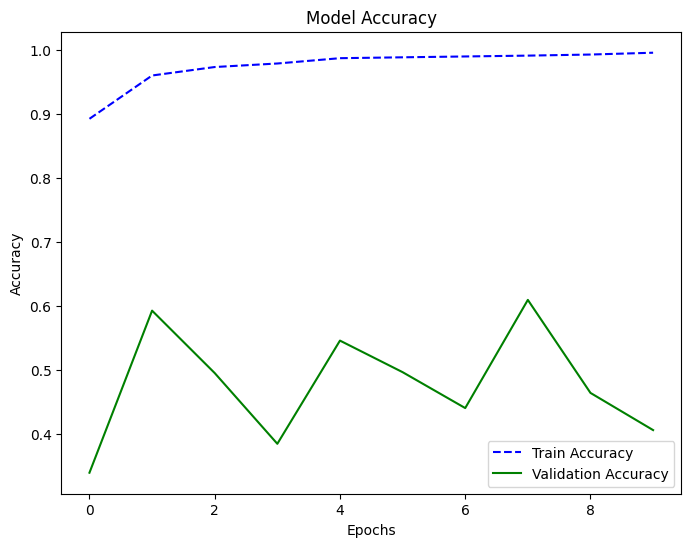

In [341]:
plt.figure(figsize=(8, 6))

plt.plot(history_5.history['accuracy'], label='Train Accuracy', color='blue', linestyle="dashed")
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy', color='green')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [343]:
y_pred_5 = final_2_model.predict(validation, steps=validation.samples // validation.batch_size + 1)
y_true = validation.classes

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


In [344]:
fpr_5, tpr_5, thresholds_1 = roc_curve(y_true, y_pred_5)
roc_auc_5 = auc(fpr_5, tpr_5)
print(f"AUC for Model 1: {roc_auc_5:.2f}")

AUC for Model 1: 0.66


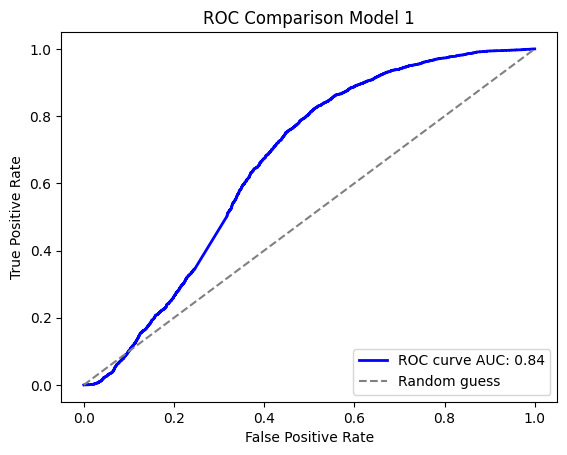

In [345]:
plt.figure()
plt.plot(fpr_5, tpr_5, color='blue', lw=2, label=f"ROC curve AUC: {roc_auc_1:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison Model 1")
plt.legend(loc='lower right')
plt.show()

In [347]:
y_pred_sample_2 = final_2_model.predict(sample)
print(y_pred_sample_2[0])

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 199s 111ms/step
[0.08445595]


In [348]:
y_pred_sample_2 = y_pred_sample_2.ravel()
submission_2 = pd.DataFrame({
    'id': sample_csv['id'],
    'label': y_pred_sample_2
})
submission_2.to_csv('CNN_submission_2.csv', index=False)

<img src="score_2.png" alt="Comp" width="500">

Even after the tuning we can see that there was not really any further improvement in the overall score. This is expected based off the ROC and AUC scores above...